# Importing Libraries

In [1]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Creating Data for Model

In [3]:
customer_transactions = transactions.groupby("CustomerID").agg(
    TotalTransactions=("TransactionID", "nunique"),
    TotalValue=("TotalValue", "sum"),
    AvgTransactionValue=("TotalValue", "mean")
).reset_index()

In [4]:
# Merge with customer profiles
customer_data = pd.merge(customers, customer_transactions, on="CustomerID", how="left")

In [5]:
customer_data.isnull().sum()

CustomerID             0
CustomerName           0
Region                 0
SignupDate             0
TotalTransactions      1
TotalValue             1
AvgTransactionValue    1
dtype: int64

In [6]:
rows_with_missing_values = customer_data[customer_data.isnull().any(axis=1)]
rows_with_missing_values


,CustomerID,CustomerName,Region,SignupDate,TotalTransactions,TotalValue,AvgTransactionValue
179,C0180,Amy Carpenter,Asia,2023-10-25,NaN,NaN,NaN


In [7]:
print(customer_data.TotalTransactions.max(), customer_data.TotalTransactions.mean(), customer_data.TotalTransactions.min())

11.0 5.025125628140704 1.0


In [8]:
print(customer_data.TotalValue.max(), customer_data.TotalValue.mean(), customer_data.TotalValue.min())

10673.869999999999 3467.314371859296 82.36


In [9]:
print(customer_data.AvgTransactionValue.max(), customer_data.AvgTransactionValue.mean(), customer_data.AvgTransactionValue.min())

1323.1333333333332 687.5801821245477 82.36


### Since there is a lot of difference between mean values and extreme values for the columns, and there is just one row with missing values, we can safely drop that row.

In [10]:
customer_data.dropna(inplace=True)

# Feature Engineering

In [11]:
features = ["Region", "TotalTransactions", "TotalValue", "AvgTransactionValue"]
customer_data_encoded = pd.get_dummies(customer_data[features], columns=["Region"], drop_first=True)

In [12]:
customer_data_encoded

,TotalTransactions,TotalValue,AvgTransactionValue,Region_Europe,Region_North America,Region_South America
0,5.0,3354.52,670.904000,False,False,True
1,4.0,1862.74,465.685000,False,False,False
2,4.0,2725.38,681.345000,False,False,True
3,8.0,5354.88,669.360000,False,False,True
4,3.0,2034.24,678.080000,False,False,False
...,...,...,...,...,...,...
195,4.0,4982.88,1245.720000,True,False,False
196,3.0,1928.65,642.883333,True,False,False
197,2.0,931.83,465.915000,True,False,False
198,4.0,1979.28,494.820000,True,False,False


# Scale features

In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data_encoded)

# clustering methods

In [14]:
num_clusters = 7  # Set number of clusters for KMeans and Hierarchical
clustering_methods = {
    "KMeans": KMeans(n_clusters=num_clusters, random_state=42),
    "Hierarchical": AgglomerativeClustering(n_clusters=num_clusters),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5)  # You can tune eps and min_samples
}

# Evaluating Each Method

In [15]:
db_scores = {}
cluster_labels = {}

for method_name, model in clustering_methods.items():
    if method_name == "DBSCAN":
        labels = model.fit_predict(scaled_features)
    else:
        labels = model.fit_predict(scaled_features)
    
    # Ignore noise (-1) labels in DBSCAN when calculating DB Index
    if method_name == "DBSCAN" and len(set(labels)) == 1:
        db_score = float("inf")  # No valid clusters formed
    else:
        db_score = davies_bouldin_score(scaled_features, labels)
    
    db_scores[method_name] = db_score
    cluster_labels[method_name] = labels
    print(f"{method_name} - Davies-Bouldin Index: {db_score}")

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans - Davies-Bouldin Index: 0.970353917315113
Hierarchical - Davies-Bouldin Index: 0.9569486112390498
DBSCAN - Davies-Bouldin Index: 1.5116554610159767


In [16]:
best_method = min(db_scores, key=db_scores.get)
best_labels = cluster_labels[best_method]
print(f"\nBest Clustering Method: {best_method} with DB Index: {db_scores[best_method]}")



Best Clustering Method: Hierarchical with DB Index: 0.9569486112390498


## Hierarchical Clustering works best

In [17]:
customer_data["Cluster"] = best_labels

# Visualize Clusters Using PCA

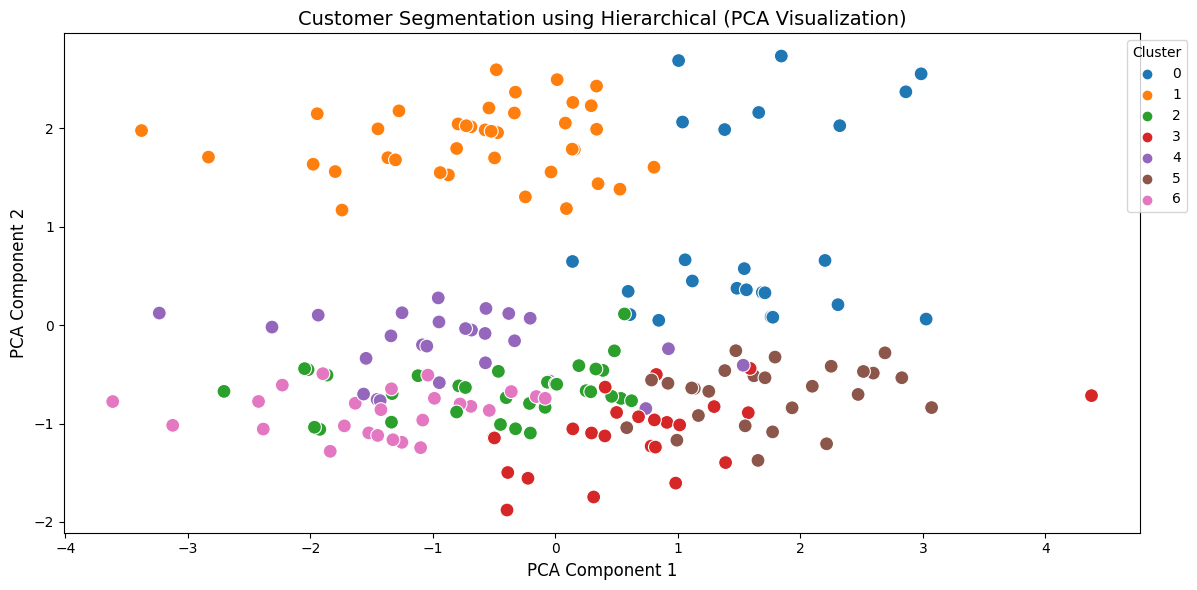

In [18]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=customer_data["Cluster"],
    palette="tab10",
    s=100
)
plt.title(f"Customer Segmentation using {best_method} (PCA Visualization)", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

## Using Dendogram

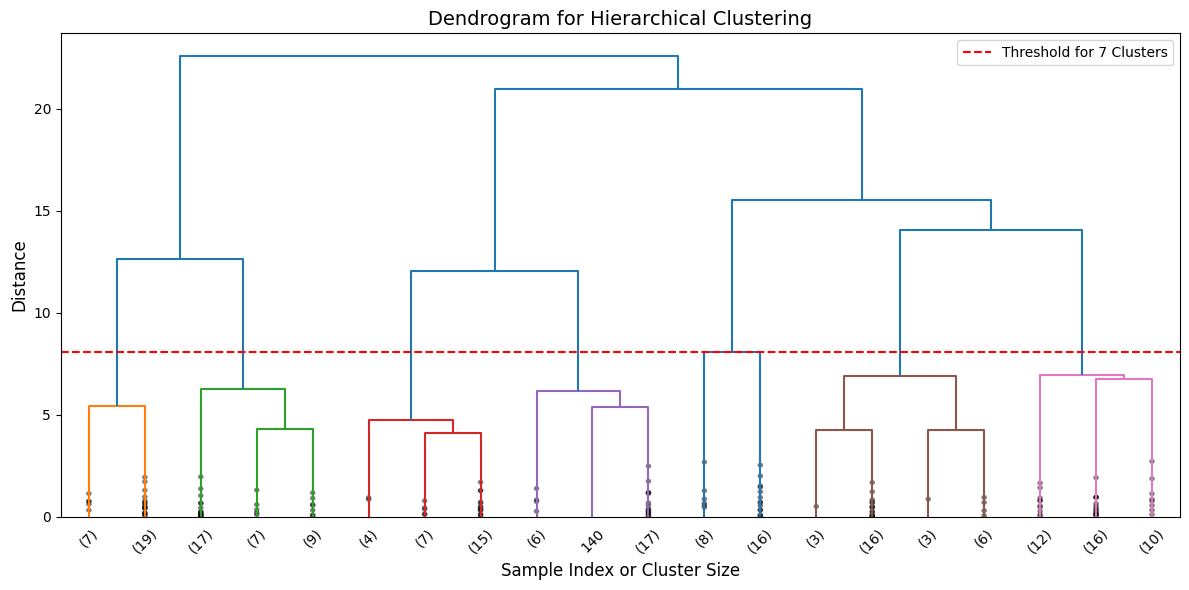

In [28]:
from scipy.cluster.hierarchy import fcluster

# Generate the linkage matrix
linkage_matrix = linkage(scaled_features, method='ward')

# Determine the distance threshold for 7 clusters
distance_threshold = linkage_matrix[-7, 2]  # Get the height at the 7th-last merge (7 clusters)

# Plot the dendrogram with the threshold
plt.figure(figsize=(12, 6))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Show only the last p merges
    p=20,  # Adjust to show relevant depth
    color_threshold=distance_threshold,  # Highlight clusters
    leaf_rotation=45,
    leaf_font_size=10,
    show_contracted=True
)
plt.axhline(y=distance_threshold, color='red', linestyle='--', label='Threshold for 7 Clusters')
plt.title("Dendrogram for Hierarchical Clustering", fontsize=14)
plt.xlabel("Sample Index or Cluster Size", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


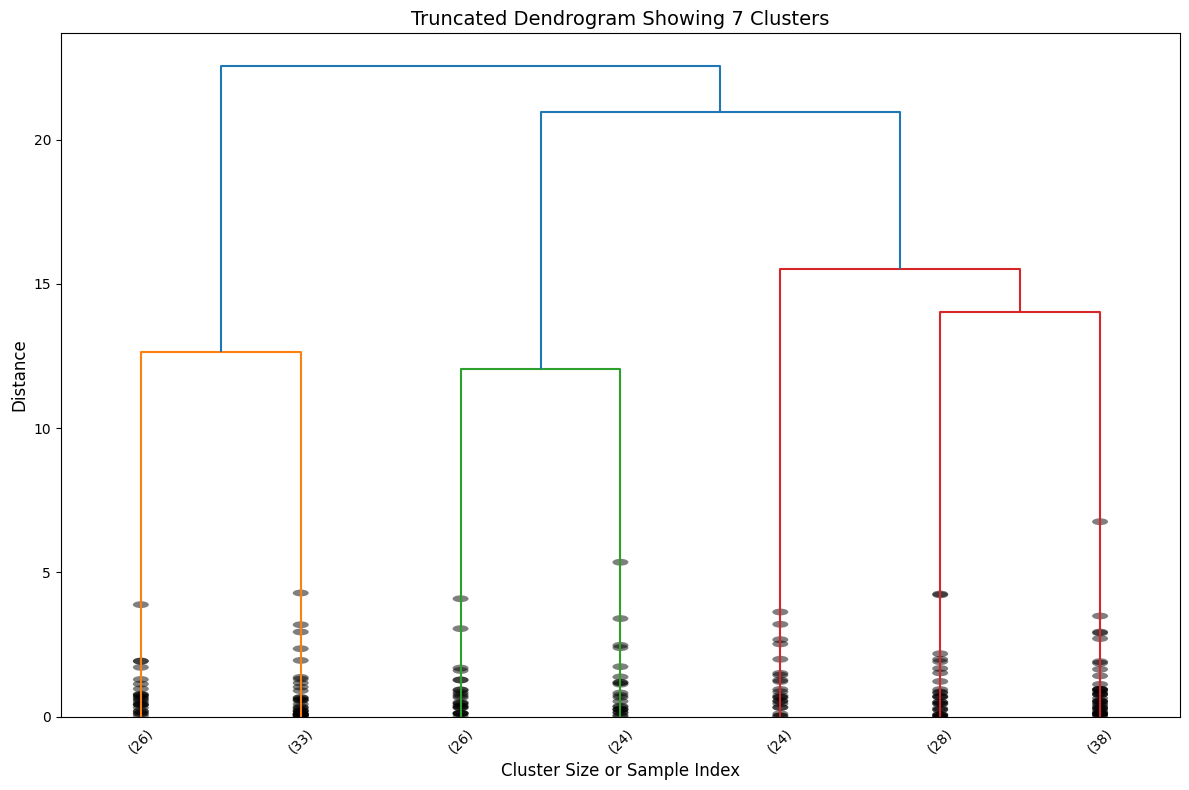

In [27]:
from scipy.cluster.hierarchy import fcluster

# Generate linkage matrix
linkage_matrix = linkage(scaled_features, method='ward')

# Generate 7 clusters
cluster_labels = fcluster(linkage_matrix, t=7, criterion='maxclust')

# Plot truncated dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Truncate to show only the last p clusters
    p=7,  # Show 7 clusters
    show_contracted=True,
    leaf_rotation=45,
    leaf_font_size=10
)
plt.title("Truncated Dendrogram Showing 7 Clusters", fontsize=14)
plt.xlabel("Cluster Size or Sample Index", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.tight_layout()
plt.show()


In [19]:
cluster_summary = customer_data.groupby("Cluster").agg(
    AvgTotalTransactions=("TotalTransactions", "mean"),
    AvgTotalValue=("TotalValue", "mean"),
    TopRegion=("Region", lambda x: x.value_counts().index[0])
)
print(cluster_summary)

         AvgTotalTransactions  AvgTotalValue      TopRegion
Cluster                                                    
0                    8.208333    5635.025417           Asia
1                    4.526316    2724.534474  North America
2                    4.151515    2367.345455  South America
3                    5.458333    4770.324583         Europe
4                    3.321429    2343.408929           Asia
5                    6.423077    5431.929231  South America
6                    3.961538    1991.032308         Europe


## Other Relevant Metrics

In [20]:
cluster_labels = cluster_labels["Hierarchical"]

assert cluster_labels.ndim == 1, "Cluster labels should be a 1D array."

In [21]:
# Calculate Silhouette Score
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_features, cluster_labels, metric="euclidean")
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3706661724268329


In [22]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(scaled_features, cluster_labels)
print(f"Calinski-Harabasz Index: {ch_score}")


Calinski-Harabasz Index: 77.5659815380935
